# Experiment: Batch Normalization vs Dropout Regularization.

In the following experiment we will study the impact of <b>batch normalization and dropout on ConvNet to reduce the loss (error)</b> 

###setup:
 
- We will define a model where we have a choice to insert batch norm or dropout after a convolutional layer. 
- We will train each variant model on the **Cifar100 dataset**. 
- Visualize the differences in validation loss between results of model with dropout, with batch normalization, and with nothing. 

- Then , repeat the same steps  by changing the locations of dropout and batch norm layers between convolutions (before, after activation functions & after maxpool). 

<b>Tips:</b>  We first place Batch Normalization & Dropout operations before activations, then after activations, and finally after max pooling layers. 


## Hypothesis: 

<b> Validation loss (Generalization error) will achieve the lowest values when batch normalization is inserted between convolutional layers.</b>, let's see if that's correct practically!



###Cifar100 dataset: 
This dataset has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. 


## Experiment Setup


### Base Convolutional Layer
These same successive conv layers will be always used in all built models below, they called "conv block" 

<img src="https://github.com/harrisonjansma/Research-Computer-Vision/blob/master/08-12-18%20Batch%20Norm%20vs%20Dropout/images/convblock.png?raw=1" height = 250>

Each model is based on the same architecure consisting of 5 convolutional blocks, and it concludes with a single fully connected layer, containing 100 units and softmax activation.

### Architecture Variants
Within each convolutional block we will place either a dropout layer, batch normalization, or nothing (control) at the same place within the convolutional block. 


For example, in the first section we place a Batch norm and dropout operation before activation functions. This makes each of the above Conv2D(3x3, ReLU) layers take this architecture :

<img src="https://github.com/harrisonjansma/Research-Computer-Vision/blob/master/08-12-18%20Batch%20Norm%20vs%20Dropout/images/Variants.png?raw=1">

### Dropout Impact
To test the effect of dropout, we will build same three models with different dropout rates: either 0.5, 0.3, or 0.1. 

### Conclusion 
<b>To conclude, in each section we will train and test a control network, a batch-normalized network, and three dropout networks (with rates of 0.5, 0.3, or 0.1), </b> and compare between their results of accuracy and loss. 
Please plot every result and comment your comparison 




### Imports

In [ ]:
import tensorflow as tf 
import numpy as np
import os

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import  array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Model, Sequential
from keras.layers import Input

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D, Dense
from keras.layers import MaxPooling2D, Dropout, Flatten

import time

### Data Loading and Preprocessing.

In [ ]:
from keras.datasets import cifar100
from keras.utils import np_utils

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

#scale and regularize the dataset inputs
x_train = (x_train-np.mean(x_train))
x_test = (x_test - x_test.mean())

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#onehot encode the target classes
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)


train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x_train,
                                     y = y_train,
                                    batch_size=80,
                                    shuffle=True,
                                    )


169001437/169001437 [==============================] - 3s 0us/step


In [ ]:
y_train.shape

(50000, 100)

# Dropout and Batch Norm before Activations

### Model Construction

In [ ]:
def input_conv_block(model, bn=False, dropout=False, rate=0.4, activation="relu"):
    """
    The first convolutional block in each architecture. Seperated so we can 
    specify the input shape.
    """
    model.add(Conv2D(60,3, padding = "same", input_shape = x_train.shape[1:]))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))    
    model.add(Activation(activation))
    
    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    model.add(Activation(activation))
    
    model.add(MaxPooling2D())
    return model

def conv_block(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    Generic convolutional block with 2 stacked 3x3 convolutions, max pooling, dropout, 
    and an optional Batch Normalization.
    """
    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    model.add(Activation(activation))
    
    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    model.add(Activation(activation))
    model.add(MaxPooling2D())
    return model

def conv_block_final(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    I bumped up the number of filters in the final block. I made this seperate so that
    I might be able to integrate Global Average Pooling later on. 
    """
    model.add(Conv2D(100,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    model.add(Activation(activation))
    
    model.add(Conv2D(100,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    model.add(Activation(activation))
    
    model.add(Flatten())
    return model

def fn_block(model):
    """
    build a very deep fully connected block.
    """
    model.add(Dense(1000, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation = "softmax"))
    return model

def build_model(blocks=3, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    Builds a sequential network based on the specified parameters.
    
    blocks: number of convolutional blocks in the network, must be greater than 2.
    bn: whether to include batch normalization or not.
    activation: activation function to use throughout the network.
    """
    model = Sequential()
    
    model = input_conv_block(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    
    for block in range(1,blocks-1):
        model = conv_block(model, bn=bn, dropout=dropout, rate=rate, activation = activation)
        
    model = conv_block_final(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    model = fn_block(model)
    
    return model

def compile_model(model, optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]): 
    """
    Compiles a neural network.
    
    model: the network to be compiled.
    optimizer: the optimizer to use.
    loss: the loss to use.
    metrics: a list of keras metrics.
    """
    model.compile(optimizer = optimizer,
                 loss = loss,
                 metrics = metrics)
    return model

### Compile Models

Now, Build the entire model, making 5 versions:

- control object: to build an architecture of 5 blocks without dropout, without BN
- batchNorm: to build an architecture of 5 blocks without dropout, with BN operation
- dropout5: to build an architecture of 5 blocks with a dropout of rate =0.5, without BN operation

- dropout3: to build an architecture of 5 blocks with a dropout of rate =0.3, without BN operation

- dropout1: to build an architecture of 5 blocks with a dropout of rate =0.1, without BN operation

Each time you build a new model object you need to compile it 


In [ ]:
control = build_model(blocks = 5, bn=False, dropout=False, activation = "relu")
control = compile_model(control) 

batchNorm = build_model(blocks = 5, bn=True, dropout=False, activation = "relu")
batchNorm = compile_model(batchNorm)

dropout5 = build_model(blocks = 5, bn=True, dropout=True, rate=0.5, activation = "relu") # build the model with propability of dropout of 0.5
dropout5 = compile_model(dropout5)

dropout3 = build_model(blocks = 5, bn=True, dropout=True, rate=0.3, activation = "relu") # build the model with propability of dropout of 0.3
dropout3 = compile_model(dropout3)

dropout1 = build_model(blocks = 5, bn=True, dropout=True, rate=0.1, activation = "relu") # build the model with propability of dropout of 0.1
dropout1 = compile_model(dropout1)

## Train the Models

In [ ]:
def trainModel(model, savedest):
    start = time.time()
    #savedest is the path of saved model that you decide to save the model on
    model_checkpoint = ModelCheckpoint(savedest,save_best_only = True)  # this confis will save the model when it gets the best performance

    history = model.fit(
        train_generator,
        steps_per_epoch=625,
        epochs=10,
        verbose=1, 
        validation_data = (x_test, y_test),
        callbacks = [model_checkpoint])

    end = time.time()

    print("Training time: ", (end - start)/60, " minutes")
    return history

def plotModel(history, modelname):
    plt.figure(figsize=(12,6))
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(modelname+' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(modelname+' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    return None

def plotAllModels(history1, history2, history3, history4, history5, title):
    plt.figure(figsize=(12,6))
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history1.history['val_accuracy'])
    plt.plot(history2.history['val_accuracy'])
    plt.plot(history3.history['val_accuracy'])
    plt.plot(history4.history['val_accuracy'])
    plt.plot(history5.history['val_accuracy'])
    plt.title(title + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Control', 'Batch Norm', 'Dropout (0.5)', 'Dropout (0.3)', 'Dropout (0.1)'], loc='upper left')
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history1.history['val_loss'])
    plt.plot(history2.history['val_loss'])
    plt.plot(history3.history['val_loss'])
    plt.plot(history4.history['val_loss'])
    plt.plot(history5.history['val_loss'])

    plt.title(title+ ' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Control', 'Batch Norm', 'Dropout', 'Dropout (0.3)', 'Dropout (0.1)'], loc='upper right')
    plt.show()
    return None

### Control Model
No dropout no batch norm.

In [ ]:
history1 = trainModel(control, 'models/control.h5')

Epoch 1/10
625/625 [==============================] - 21s 18ms/step - loss: 4.2018 - accuracy: 0.0499 - val_loss: 3.8848 - val_accuracy: 0.0922
Epoch 2/10
625/625 [==============================] - 11s 17ms/step - loss: 3.6800 - accuracy: 0.1282 - val_loss: 3.4853 - val_accuracy: 0.1677
Epoch 3/10
625/625 [==============================] - 11s 17ms/step - loss: 3.3857 - accuracy: 0.1798 - val_loss: 3.3159 - val_accuracy: 0.1983
Epoch 4/10
625/625 [==============================] - 11s 17ms/step - loss: 3.2119 - accuracy: 0.2142 - val_loss: 3.1168 - val_accuracy: 0.2298
Epoch 5/10
625/625 [==============================] - 11s 17ms/step - loss: 3.0901 - accuracy: 0.2361 - val_loss: 3.0861 - val_accuracy: 0.2429
Epoch 6/10
625/625 [==============================] - 11s 17ms/step - loss: 3.0033 - accuracy: 0.2537 - val_loss: 3.0293 - val_accuracy: 0.2460
Epoch 7/10
625/625 [==============================] - 10s 17ms/step - loss: 2.9453 - accuracy: 0.2670 - val_loss: 3.0373 - val_accuracy:

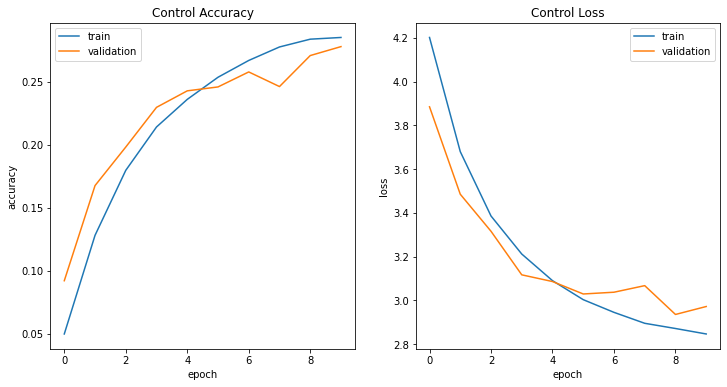

In [ ]:
plotModel(history1, "Control")

##Interpretation
We can see that with the Control Model (without Batch Normalization and Dropout) the result is pretty of moderate performance .

### Batch Normalization
Batch norm after convolutions and prior to activations.

In [ ]:
history2 = trainModel(batchNorm, 'models/batchNorm.h5')

Epoch 1/10
625/625 [==============================] - 15s 21ms/step - loss: 3.8303 - accuracy: 0.1042 - val_loss: 3.8216 - val_accuracy: 0.1287
Epoch 2/10
625/625 [==============================] - 13s 20ms/step - loss: 3.0522 - accuracy: 0.2262 - val_loss: 2.8545 - val_accuracy: 0.2745
Epoch 3/10
625/625 [==============================] - 13s 20ms/step - loss: 2.6101 - accuracy: 0.3125 - val_loss: 2.7760 - val_accuracy: 0.2927
Epoch 4/10
625/625 [==============================] - 13s 20ms/step - loss: 2.3449 - accuracy: 0.3703 - val_loss: 2.6418 - val_accuracy: 0.3304
Epoch 5/10
625/625 [==============================] - 13s 20ms/step - loss: 2.1480 - accuracy: 0.4167 - val_loss: 2.4658 - val_accuracy: 0.3746
Epoch 6/10
625/625 [==============================] - 13s 20ms/step - loss: 1.9873 - accuracy: 0.4539 - val_loss: 2.4017 - val_accuracy: 0.3841
Epoch 7/10
625/625 [==============================] - 14s 22ms/step - loss: 1.8561 - accuracy: 0.4846 - val_loss: 2.7744 - val_accuracy:

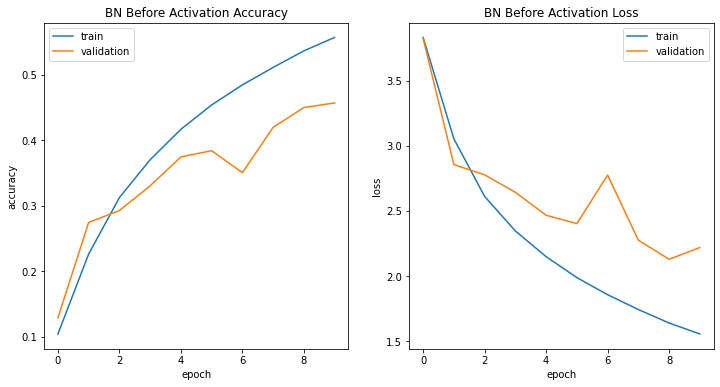

In [ ]:
plotModel(history2, "BN Before Activation")

### Dropout 0.5
Dropout prior to activation with rate 0.5

In [ ]:
history3 = trainModel(dropout5, 'models/Dropout5.h5')

Epoch 1/10
625/625 [==============================] - 18s 24ms/step - loss: 4.4079 - accuracy: 0.0242 - val_loss: 4.6982 - val_accuracy: 0.0129
Epoch 2/10
625/625 [==============================] - 15s 24ms/step - loss: 4.1054 - accuracy: 0.0474 - val_loss: 4.5784 - val_accuracy: 0.0234
Epoch 3/10
625/625 [==============================] - 14s 23ms/step - loss: 3.9437 - accuracy: 0.0660 - val_loss: 4.7207 - val_accuracy: 0.0161
Epoch 4/10
625/625 [==============================] - 14s 23ms/step - loss: 3.8098 - accuracy: 0.0838 - val_loss: 4.8359 - val_accuracy: 0.0230
Epoch 5/10
625/625 [==============================] - 15s 23ms/step - loss: 3.7023 - accuracy: 0.1034 - val_loss: 4.8490 - val_accuracy: 0.0182
Epoch 6/10
625/625 [==============================] - 14s 23ms/step - loss: 3.6227 - accuracy: 0.1146 - val_loss: 4.7955 - val_accuracy: 0.0219
Epoch 7/10
625/625 [==============================] - 14s 23ms/step - loss: 3.5606 - accuracy: 0.1242 - val_loss: 4.8934 - val_accuracy:

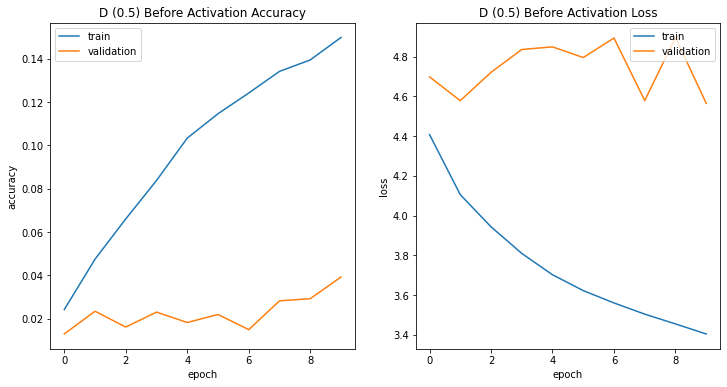

In [ ]:
plotModel(history3, "D (0.5) Before Activation")

### Dropout 0.3
Dropout prior to activation with rate 0.3

In [ ]:
history4 = trainModel(dropout3, 'models/Dropout3.h5')

Epoch 1/10
625/625 [==============================] - 17s 24ms/step - loss: 4.1845 - accuracy: 0.0486 - val_loss: 4.4008 - val_accuracy: 0.0322
Epoch 2/10
625/625 [==============================] - 14s 23ms/step - loss: 3.7707 - accuracy: 0.0977 - val_loss: 4.5027 - val_accuracy: 0.0437
Epoch 3/10
625/625 [==============================] - 15s 23ms/step - loss: 3.4935 - accuracy: 0.1443 - val_loss: 4.1948 - val_accuracy: 0.0678
Epoch 4/10
625/625 [==============================] - 15s 23ms/step - loss: 3.2845 - accuracy: 0.1814 - val_loss: 4.0949 - val_accuracy: 0.0710
Epoch 5/10
625/625 [==============================] - 14s 23ms/step - loss: 3.1291 - accuracy: 0.2115 - val_loss: 4.0436 - val_accuracy: 0.1014
Epoch 6/10
625/625 [==============================] - 14s 23ms/step - loss: 2.9983 - accuracy: 0.2350 - val_loss: 3.7256 - val_accuracy: 0.1093
Epoch 7/10
625/625 [==============================] - 15s 23ms/step - loss: 2.9069 - accuracy: 0.2556 - val_loss: 3.6581 - val_accuracy:

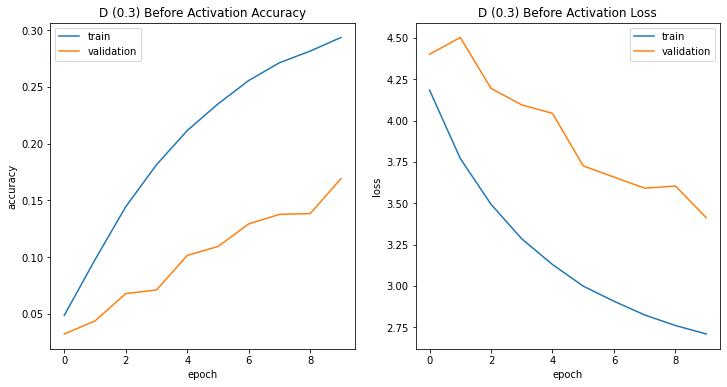

In [ ]:
plotModel(history4, "D (0.3) Before Activation")

### Dropout 0.1
Dropout prior to activation with rate 0.1

In [ ]:
history5 = trainModel(dropout1, 'models/Dropout1.h5')

Epoch 1/10
625/625 [==============================] - 17s 24ms/step - loss: 3.9543 - accuracy: 0.0819 - val_loss: 3.5589 - val_accuracy: 0.1359
Epoch 2/10
625/625 [==============================] - 15s 23ms/step - loss: 3.3242 - accuracy: 0.1754 - val_loss: 3.4047 - val_accuracy: 0.1658
Epoch 3/10
625/625 [==============================] - 14s 23ms/step - loss: 2.9407 - accuracy: 0.2480 - val_loss: 3.2592 - val_accuracy: 0.1957
Epoch 4/10
625/625 [==============================] - 15s 24ms/step - loss: 2.6957 - accuracy: 0.2945 - val_loss: 2.6846 - val_accuracy: 0.2970
Epoch 5/10
625/625 [==============================] - 15s 23ms/step - loss: 2.5089 - accuracy: 0.3339 - val_loss: 2.5261 - val_accuracy: 0.3322
Epoch 6/10
625/625 [==============================] - 14s 23ms/step - loss: 2.3815 - accuracy: 0.3630 - val_loss: 2.8401 - val_accuracy: 0.2923
Epoch 7/10
625/625 [==============================] - 14s 23ms/step - loss: 2.2751 - accuracy: 0.3892 - val_loss: 2.4076 - val_accuracy:

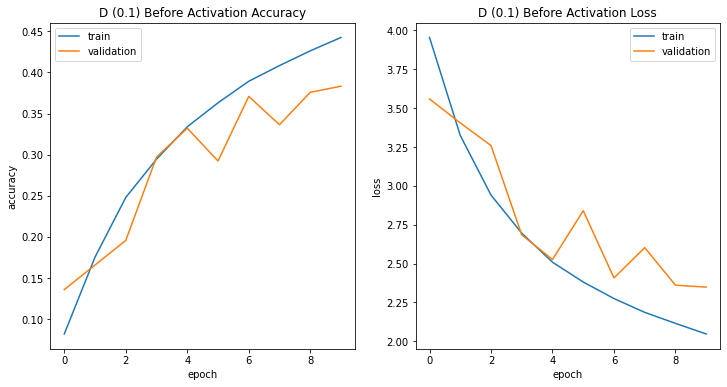

In [ ]:
plotModel(history5, "D (0.1) Before Activation")

### Performance of BN and Dropout before activations
Plot  the performance (accuracies and losses) of all 5 models plotted together. 

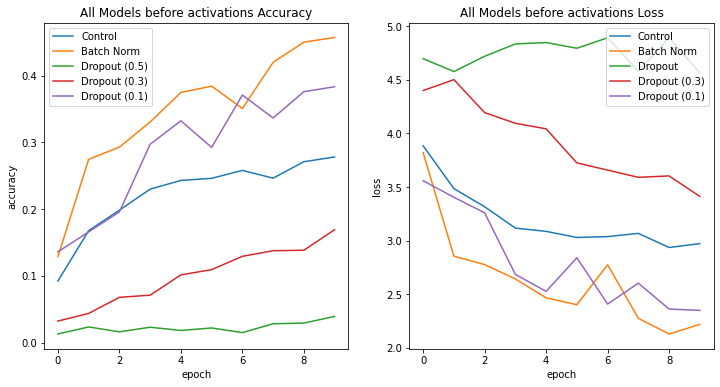

In [ ]:
plotAllModels(history1, history2, history3, history4, history5, "All Models before activations")

##What is your conclusion from the first build ?


# Let's try Dropout and Batch norm after activations

## Model Construction

Rebuild the same blocks, changing the order of BN and Dropout operations to be after activation function 

In [ ]:
def input_conv_block(model, bn=False, dropout=False, rate=0.4, activation="relu"):
    """
    The first convolutional block in each architecture. Seperated so we can 
    specify the input shape.
    """
    model.add(Conv2D(60,3, padding = "same", input_shape = x_train.shape[1:]))
    
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))    
    
    
    
    
    model.add(Conv2D(60,3, padding = "same"))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    
    
    
    
    model.add(MaxPooling2D())    
    
    return model

def conv_block(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
  """
  Generic convolutional block with 2 stacked 3x3 convolutions, max pooling, dropout, 
  and an optional Batch Normalization.
  """
  model.add(Conv2D(60,3, padding = "same"))
  model.add(Activation(activation))
  if bn:
      model.add(BatchNormalization())
  if dropout:
      model.add(Dropout(rate))  
  
  
  model.add(Conv2D(60,3, padding = "same"))
  model.add(Activation(activation))
  if bn:
      model.add(BatchNormalization())
  if dropout:
      model.add(Dropout(rate))  
  model.add(MaxPooling2D())
  
  return model

def conv_block_final(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    I bumped up the number of filters in the final block. I made this seperate so that
    I might be able to integrate Global Average Pooling later on. 
    """
    model.add(Conv2D(100,3, padding = "same"))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    
    
    model.add(Conv2D(100,3, padding = "same"))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    
    model.add(Flatten())
    

    return model

def fn_block(model):
    
    model.add(Dense(1000, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation = "softmax"))

    return model

def build_model(blocks=3, bn=False, dropout=False, rate=0.5, activation = "relu"):
    
    model = Sequential()
    
    model = input_conv_block(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    
    for block in range(1,blocks-1):
        model = conv_block(model, bn=bn, dropout=dropout, rate=rate, activation = activation)
        
    model = conv_block_final(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    model = fn_block(model)
    
    return model

def compile_model(model, optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]): 
    
    model.compile(optimizer = optimizer,
                 loss = loss,
                 metrics = metrics)
    return model

### Compile the Models

In [ ]:
control = build_model(blocks = 5, bn=False, dropout=False, activation = "relu")
control = compile_model(control) 

batchNorm = build_model(blocks = 5, bn=True, dropout=False, activation = "relu")
batchNorm = compile_model(batchNorm)

dropout5 = build_model(blocks = 5, bn=True, dropout=True, rate=0.5, activation = "relu") # build the model with propability of dropout of 0.5
dropout5 = compile_model(dropout5)

dropout3 = build_model(blocks = 5, bn=True, dropout=True, rate=0.3, activation = "relu") # build the model with propability of dropout of 0.3
dropout3 = compile_model(dropout3)

dropout1 = build_model(blocks = 5, bn=True, dropout=True, rate=0.1, activation = "relu") # build the model with propability of dropout of 0.1
dropout1 = compile_model(dropout1)

## Training the Models

### Control

In [ ]:
history6 = trainModel(control, 'models/control.h5')

Epoch 1/10
625/625 [==============================] - 12s 17ms/step - loss: 4.2314 - accuracy: 0.0462 - val_loss: 3.8545 - val_accuracy: 0.0940
Epoch 2/10
625/625 [==============================] - 10s 17ms/step - loss: 3.7059 - accuracy: 0.1208 - val_loss: 3.4830 - val_accuracy: 0.1667
Epoch 3/10
625/625 [==============================] - 10s 17ms/step - loss: 3.4129 - accuracy: 0.1773 - val_loss: 3.3581 - val_accuracy: 0.1836
Epoch 4/10
625/625 [==============================] - 10s 17ms/step - loss: 3.2129 - accuracy: 0.2128 - val_loss: 3.1523 - val_accuracy: 0.2251
Epoch 5/10
625/625 [==============================] - 10s 16ms/step - loss: 3.0740 - accuracy: 0.2399 - val_loss: 3.0654 - val_accuracy: 0.2507
Epoch 6/10
625/625 [==============================] - 11s 17ms/step - loss: 2.9747 - accuracy: 0.2607 - val_loss: 3.0341 - val_accuracy: 0.2525
Epoch 7/10
625/625 [==============================] - 10s 17ms/step - loss: 2.9029 - accuracy: 0.2739 - val_loss: 2.9628 - val_accuracy:

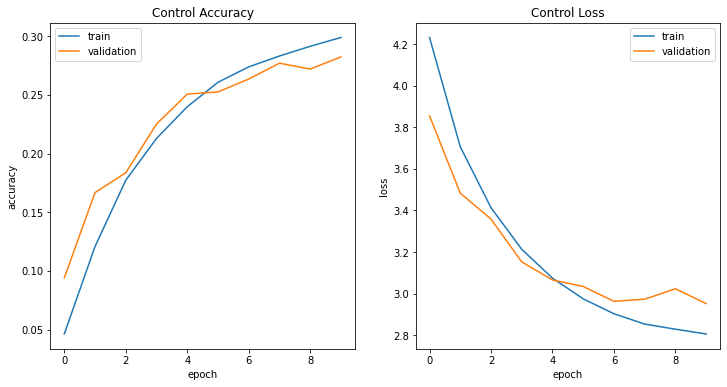

In [ ]:
plotModel(history6, "Control")

### Batch Norm

In [ ]:
history7 = trainModel(batchNorm, 'models/batchNorm.h5')

Epoch 1/10
625/625 [==============================] - 15s 21ms/step - loss: 3.7883 - accuracy: 0.1210 - val_loss: 3.5103 - val_accuracy: 0.1854
Epoch 2/10
625/625 [==============================] - 14s 22ms/step - loss: 3.0345 - accuracy: 0.2389 - val_loss: 2.9587 - val_accuracy: 0.2660
Epoch 3/10
625/625 [==============================] - 13s 20ms/step - loss: 2.6468 - accuracy: 0.3128 - val_loss: 2.5777 - val_accuracy: 0.3351
Epoch 4/10
625/625 [==============================] - 13s 21ms/step - loss: 2.4182 - accuracy: 0.3642 - val_loss: 2.4661 - val_accuracy: 0.3665
Epoch 5/10
625/625 [==============================] - 13s 21ms/step - loss: 2.2295 - accuracy: 0.4092 - val_loss: 2.2752 - val_accuracy: 0.4077
Epoch 6/10
625/625 [==============================] - 13s 20ms/step - loss: 2.0779 - accuracy: 0.4423 - val_loss: 2.2523 - val_accuracy: 0.4136
Epoch 7/10
625/625 [==============================] - 13s 20ms/step - loss: 1.9577 - accuracy: 0.4702 - val_loss: 2.1576 - val_accuracy:

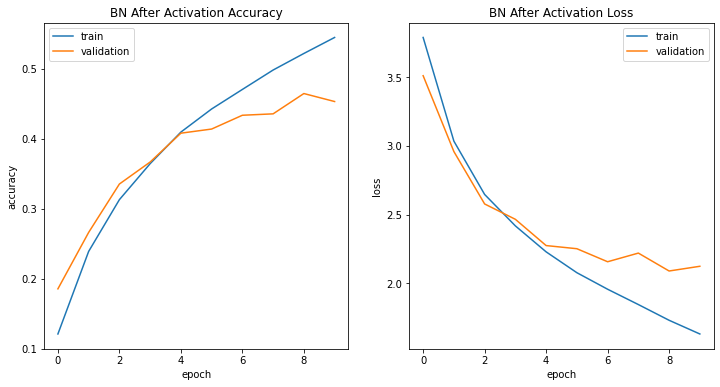

In [ ]:
plotModel(history7, "BN After Activation")

### Dropout 0.5

In [ ]:
history8 = trainModel(dropout5, 'models/Dropout5.h5')

Epoch 1/10
625/625 [==============================] - 17s 24ms/step - loss: 4.5163 - accuracy: 0.0235 - val_loss: 4.5310 - val_accuracy: 0.0275
Epoch 2/10
625/625 [==============================] - 15s 24ms/step - loss: 4.1296 - accuracy: 0.0505 - val_loss: 4.8645 - val_accuracy: 0.0335
Epoch 3/10
625/625 [==============================] - 15s 24ms/step - loss: 3.9846 - accuracy: 0.0687 - val_loss: 4.8747 - val_accuracy: 0.0487
Epoch 4/10
625/625 [==============================] - 15s 23ms/step - loss: 3.8656 - accuracy: 0.0853 - val_loss: 4.9205 - val_accuracy: 0.0524
Epoch 5/10
625/625 [==============================] - 14s 23ms/step - loss: 3.7718 - accuracy: 0.0961 - val_loss: 5.2187 - val_accuracy: 0.0377
Epoch 6/10
625/625 [==============================] - 15s 23ms/step - loss: 3.6683 - accuracy: 0.1144 - val_loss: 4.5624 - val_accuracy: 0.0536
Epoch 7/10
625/625 [==============================] - 15s 23ms/step - loss: 3.5803 - accuracy: 0.1287 - val_loss: 5.2525 - val_accuracy:

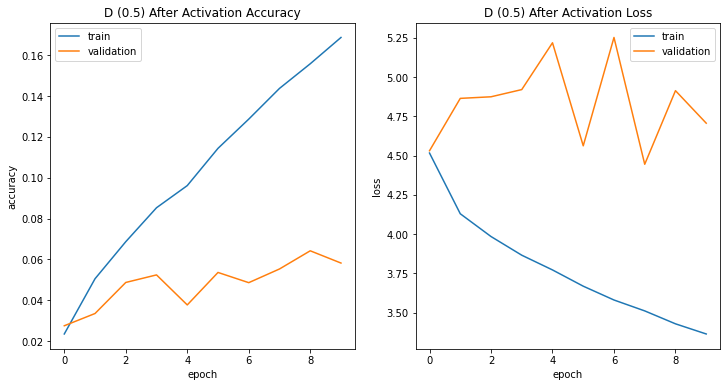

In [ ]:
plotModel(history8, "D (0.5) After Activation")

### Dropout 0.3

In [ ]:
history9 = trainModel(dropout3, 'models/Dropout3.h5')

Epoch 1/10
625/625 [==============================] - 18s 24ms/step - loss: 4.2406 - accuracy: 0.0516 - val_loss: 3.9966 - val_accuracy: 0.0664
Epoch 2/10
625/625 [==============================] - 15s 23ms/step - loss: 3.7873 - accuracy: 0.1055 - val_loss: 3.7647 - val_accuracy: 0.1127
Epoch 3/10
625/625 [==============================] - 14s 23ms/step - loss: 3.5173 - accuracy: 0.1468 - val_loss: 4.7201 - val_accuracy: 0.1110
Epoch 4/10
625/625 [==============================] - 15s 24ms/step - loss: 3.3240 - accuracy: 0.1818 - val_loss: 4.1592 - val_accuracy: 0.1306
Epoch 5/10
625/625 [==============================] - 15s 24ms/step - loss: 3.1808 - accuracy: 0.2103 - val_loss: 3.6794 - val_accuracy: 0.1636
Epoch 6/10
625/625 [==============================] - 15s 23ms/step - loss: 3.0564 - accuracy: 0.2363 - val_loss: 3.6447 - val_accuracy: 0.1774
Epoch 7/10
625/625 [==============================] - 15s 23ms/step - loss: 2.9442 - accuracy: 0.2554 - val_loss: 3.4403 - val_accuracy:

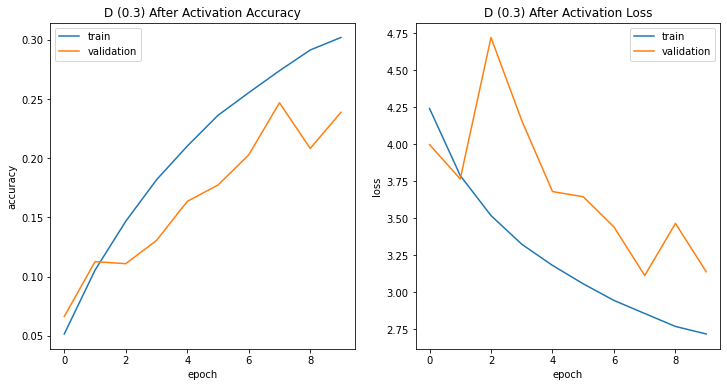

In [ ]:
plotModel(history9, "D (0.3) After Activation")

### Dropout 0.1

In [ ]:
history10 = trainModel(dropout1, 'models/Dropout1.h5')

Epoch 1/10
625/625 [==============================] - 17s 24ms/step - loss: 3.9745 - accuracy: 0.0893 - val_loss: 3.4841 - val_accuracy: 0.1710
Epoch 2/10
625/625 [==============================] - 15s 24ms/step - loss: 3.3584 - accuracy: 0.1804 - val_loss: 3.2204 - val_accuracy: 0.2122
Epoch 3/10
625/625 [==============================] - 15s 23ms/step - loss: 3.0003 - accuracy: 0.2447 - val_loss: 3.0476 - val_accuracy: 0.2544
Epoch 4/10
625/625 [==============================] - 15s 24ms/step - loss: 2.7446 - accuracy: 0.2960 - val_loss: 2.6475 - val_accuracy: 0.3241
Epoch 5/10
625/625 [==============================] - 14s 23ms/step - loss: 2.5705 - accuracy: 0.3326 - val_loss: 2.4965 - val_accuracy: 0.3484
Epoch 6/10
625/625 [==============================] - 14s 23ms/step - loss: 2.4350 - accuracy: 0.3648 - val_loss: 2.4049 - val_accuracy: 0.3704
Epoch 7/10
625/625 [==============================] - 15s 24ms/step - loss: 2.3197 - accuracy: 0.3877 - val_loss: 2.2963 - val_accuracy:

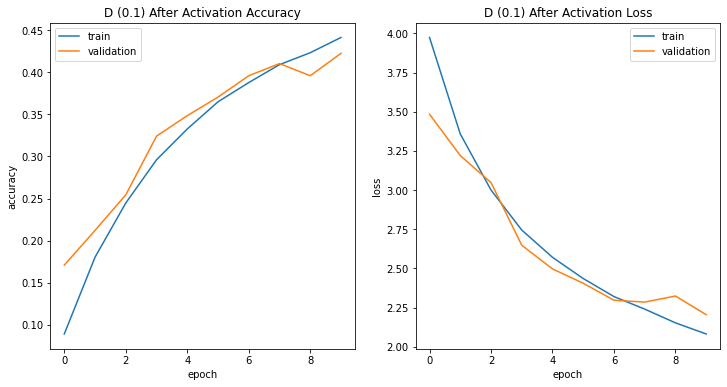

In [ ]:
plotModel(history10, "D (0.1) After Activation")

### Performance of BN and Dropout after activations
Plot the performances (accuracies and loss ) of all models together

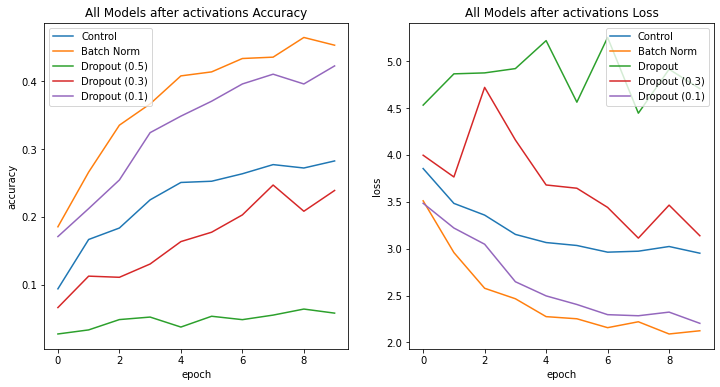

In [ ]:
plotAllModels(history6, history7, history8, history9, history10, "All Models after activations")

# Let's try to add BN and Dropout after maxpooling
Rebuild the same blocks, changing the order of BN and Dropout operations to be after Maxpooling 
## Model Construction

In [ ]:
def input_conv_block(model, bn=False, dropout=False, rate=0.4, activation="relu"):
    """
    The first convolutional block in each architecture. Seperated so we can 
    specify the input shape.
    """
    model.add(Conv2D(60,3, padding = "same", input_shape = x_train.shape[1:]))
    model.add(MaxPooling2D())
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))
    
    model.add(Conv2D(60,3, padding = "same"))  
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))
    return model
    
def conv_block(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    Generic convolutional block with 2 stacked 3x3 convolutions, max pooling, dropout, 
    and an optional Batch Normalization.
    """
    model.add(Conv2D(60,3, padding = "same"))
    model.add(MaxPooling2D())
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    model.add(Activation(activation))
    
    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    model.add(Activation(activation))
    return model

def conv_block_final(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    I bumped up the number of filters in the final block. I made this seperate so that
    I might be able to integrate Global Average Pooling later on. 
    """
    model.add(Conv2D(100,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    model.add(Activation(activation))
    
    model.add(Conv2D(100,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    model.add(Activation(activation))
    
    model.add(Flatten())
    return model

def fn_block(model):
    """
    build a very deep fully connected block.
    """
    model.add(Dense(1000, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation = "softmax"))
    return model

def build_model(blocks=3, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    Builds a sequential network based on the specified parameters.
    
    blocks: number of convolutional blocks in the network, must be greater than 2.
    bn: whether to include batch normalization or not.
    activation: activation function to use throughout the network.
    """
    model = Sequential()
    
    model = input_conv_block(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    
    for block in range(1,blocks-1):
        model = conv_block(model, bn=bn, dropout=dropout, rate=rate, activation = activation)
        
    model = conv_block_final(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    model = fn_block(model)
    
    return model

def compile_model(model, optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]): 
    """
    Compiles a neural network.
    
    model: the network to be compiled.
    optimizer: the optimizer to use.
    loss: the loss to use.
    metrics: a list of keras metrics.
    """
    model.compile(optimizer = optimizer,
                 loss = loss,
                 metrics = metrics)
    return model
    

### Compile the models

In [ ]:
control = build_model(blocks = 5, bn=False, dropout=False, activation = "relu")
control = compile_model(control) 

batchNorm = build_model(blocks = 5, bn=True, dropout=False, activation = "relu")
batchNorm = compile_model(batchNorm)

dropout5 = build_model(blocks = 5, bn=True, dropout=True, rate=0.5, activation = "relu") # build the model with propability of dropout of 0.5
dropout5 = compile_model(dropout5)

dropout3 = build_model(blocks = 5, bn=True, dropout=True, rate=0.3, activation = "relu") # build the model with propability of dropout of 0.3
dropout3 = compile_model(dropout3)

dropout1 = build_model(blocks = 5, bn=True, dropout=True, rate=0.1, activation = "relu") # build the model with propability of dropout of 0.1
dropout1 = compile_model(dropout1)

## Train the models

### Control Model

In [ ]:
history11 = trainModel(control, 'models/control.h5')

Epoch 1/10
625/625 [==============================] - 10s 14ms/step - loss: 4.2213 - accuracy: 0.0478 - val_loss: 3.8784 - val_accuracy: 0.0857
Epoch 2/10
625/625 [==============================] - 8s 12ms/step - loss: 3.7689 - accuracy: 0.1102 - val_loss: 3.8024 - val_accuracy: 0.1071
Epoch 3/10
625/625 [==============================] - 8s 12ms/step - loss: 3.5272 - accuracy: 0.1531 - val_loss: 3.4169 - val_accuracy: 0.1802
Epoch 4/10
625/625 [==============================] - 8s 12ms/step - loss: 3.3611 - accuracy: 0.1839 - val_loss: 3.2796 - val_accuracy: 0.2029
Epoch 5/10
625/625 [==============================] - 8s 13ms/step - loss: 3.2358 - accuracy: 0.2118 - val_loss: 3.2789 - val_accuracy: 0.2118
Epoch 6/10
625/625 [==============================] - 8s 13ms/step - loss: 3.1402 - accuracy: 0.2284 - val_loss: 3.2716 - val_accuracy: 0.2045
Epoch 7/10
625/625 [==============================] - 8s 12ms/step - loss: 3.0868 - accuracy: 0.2418 - val_loss: 3.1310 - val_accuracy: 0.230

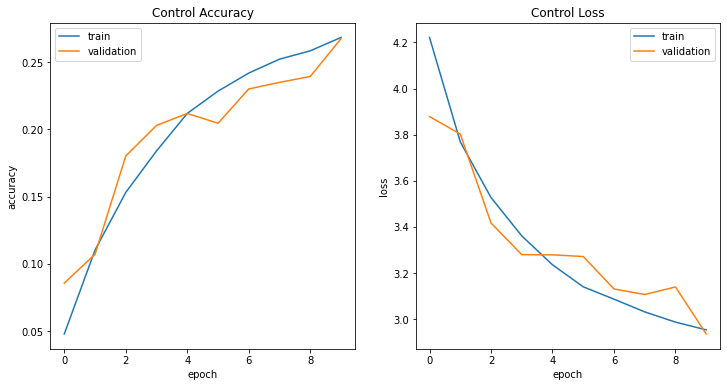

In [ ]:
plotModel(history11, "Control")

### Batch Norm

In [ ]:
history12 = trainModel(batchNorm, 'models/batchNorm.h5')

Epoch 1/10
625/625 [==============================] - 12s 16ms/step - loss: 3.8786 - accuracy: 0.0977 - val_loss: 3.4830 - val_accuracy: 0.1617
Epoch 2/10
625/625 [==============================] - 9s 15ms/step - loss: 3.1870 - accuracy: 0.2069 - val_loss: 3.0131 - val_accuracy: 0.2429
Epoch 3/10
625/625 [==============================] - 9s 15ms/step - loss: 2.7887 - accuracy: 0.2828 - val_loss: 2.7269 - val_accuracy: 0.3007
Epoch 4/10
625/625 [==============================] - 9s 14ms/step - loss: 2.5238 - accuracy: 0.3382 - val_loss: 2.6428 - val_accuracy: 0.3272
Epoch 5/10
625/625 [==============================] - 9s 15ms/step - loss: 2.3122 - accuracy: 0.3845 - val_loss: 2.5571 - val_accuracy: 0.3504
Epoch 6/10
625/625 [==============================] - 9s 15ms/step - loss: 2.1624 - accuracy: 0.4169 - val_loss: 2.4008 - val_accuracy: 0.3739
Epoch 7/10
625/625 [==============================] - 9s 15ms/step - loss: 2.0263 - accuracy: 0.4477 - val_loss: 2.3247 - val_accuracy: 0.403

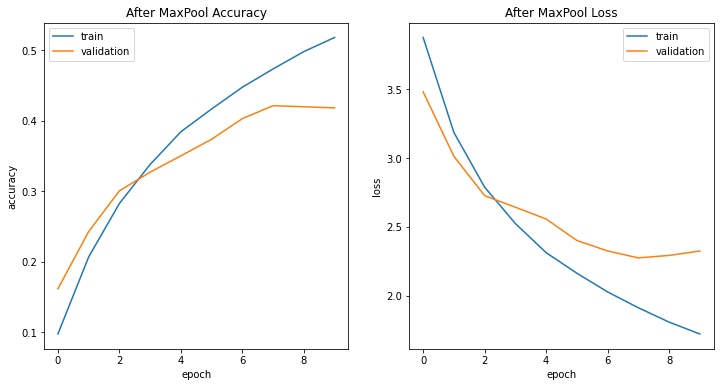

In [ ]:
plotModel(history12, "After MaxPool")

### Dropout 0.5

In [ ]:
history13 = trainModel(dropout5, 'models/Dropout5.h5')

Epoch 1/10
625/625 [==============================] - 12s 16ms/step - loss: 4.4614 - accuracy: 0.0224 - val_loss: 5.3192 - val_accuracy: 0.0106
Epoch 2/10
625/625 [==============================] - 10s 15ms/step - loss: 4.2506 - accuracy: 0.0333 - val_loss: 4.2561 - val_accuracy: 0.0352
Epoch 3/10
625/625 [==============================] - 10s 15ms/step - loss: 4.1468 - accuracy: 0.0436 - val_loss: 4.1498 - val_accuracy: 0.0490
Epoch 4/10
625/625 [==============================] - 10s 15ms/step - loss: 4.0583 - accuracy: 0.0529 - val_loss: 4.0451 - val_accuracy: 0.0586
Epoch 5/10
625/625 [==============================] - 10s 15ms/step - loss: 3.9902 - accuracy: 0.0624 - val_loss: 4.1126 - val_accuracy: 0.0537
Epoch 6/10
625/625 [==============================] - 10s 15ms/step - loss: 3.9310 - accuracy: 0.0715 - val_loss: 3.9083 - val_accuracy: 0.0752
Epoch 7/10
625/625 [==============================] - 10s 16ms/step - loss: 3.8850 - accuracy: 0.0754 - val_loss: 3.9144 - val_accuracy:

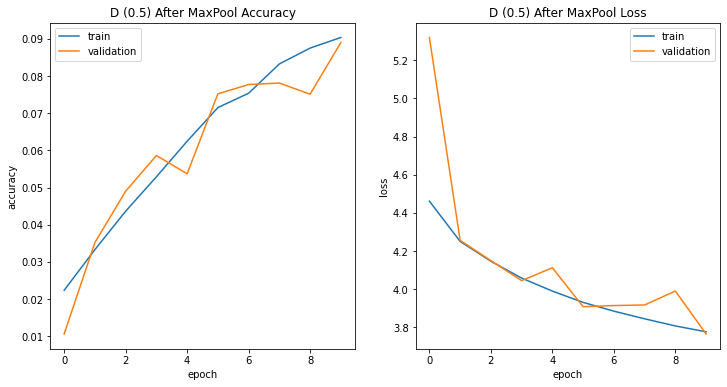

In [ ]:
plotModel(history13, "D (0.5) After MaxPool")

### Dropout 0.3

In [ ]:
history14 = trainModel(dropout3, 'models/Dropout3.h5')

Epoch 1/10
625/625 [==============================] - 12s 16ms/step - loss: 4.3447 - accuracy: 0.0305 - val_loss: 4.0699 - val_accuracy: 0.0416
Epoch 2/10
625/625 [==============================] - 10s 15ms/step - loss: 4.0227 - accuracy: 0.0567 - val_loss: 3.8303 - val_accuracy: 0.0829
Epoch 3/10
625/625 [==============================] - 10s 16ms/step - loss: 3.7932 - accuracy: 0.0877 - val_loss: 3.6771 - val_accuracy: 0.1067
Epoch 4/10
625/625 [==============================] - 10s 16ms/step - loss: 3.6335 - accuracy: 0.1092 - val_loss: 3.5705 - val_accuracy: 0.1291
Epoch 5/10
625/625 [==============================] - 10s 16ms/step - loss: 3.5038 - accuracy: 0.1356 - val_loss: 3.2903 - val_accuracy: 0.1760
Epoch 6/10
625/625 [==============================] - 10s 16ms/step - loss: 3.3998 - accuracy: 0.1502 - val_loss: 3.1451 - val_accuracy: 0.1969
Epoch 7/10
625/625 [==============================] - 10s 16ms/step - loss: 3.3215 - accuracy: 0.1693 - val_loss: 3.0915 - val_accuracy:

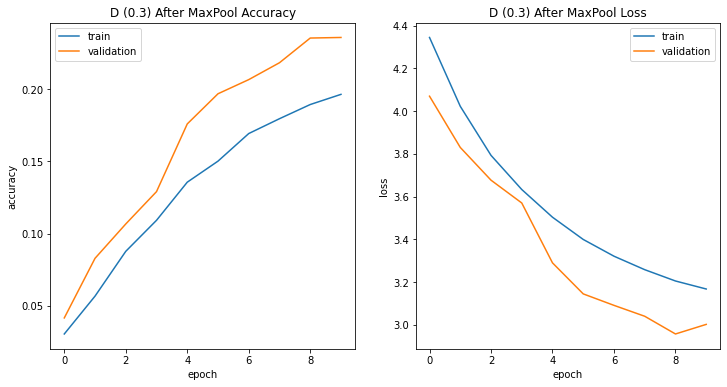

In [ ]:
plotModel(history14, "D (0.3) After MaxPool")

### Dropout 0.1

In [ ]:
history15 = trainModel(dropout1, 'models/Dropout1.h5')

Epoch 1/10
625/625 [==============================] - 12s 16ms/step - loss: 4.1169 - accuracy: 0.0586 - val_loss: 3.6264 - val_accuracy: 0.1230
Epoch 2/10
625/625 [==============================] - 10s 15ms/step - loss: 3.5620 - accuracy: 0.1298 - val_loss: 3.4424 - val_accuracy: 0.1557
Epoch 3/10
625/625 [==============================] - 10s 16ms/step - loss: 3.2625 - accuracy: 0.1875 - val_loss: 3.0393 - val_accuracy: 0.2246
Epoch 4/10
625/625 [==============================] - 10s 15ms/step - loss: 3.0445 - accuracy: 0.2273 - val_loss: 2.8289 - val_accuracy: 0.2647
Epoch 5/10
625/625 [==============================] - 10s 16ms/step - loss: 2.8621 - accuracy: 0.2611 - val_loss: 2.6485 - val_accuracy: 0.3063
Epoch 6/10
625/625 [==============================] - 10s 15ms/step - loss: 2.7357 - accuracy: 0.2898 - val_loss: 2.5928 - val_accuracy: 0.3143
Epoch 7/10
625/625 [==============================] - 10s 16ms/step - loss: 2.6213 - accuracy: 0.3132 - val_loss: 2.4921 - val_accuracy:

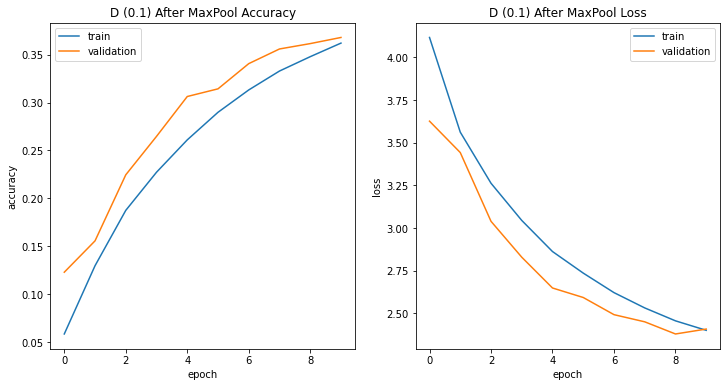

In [ ]:
plotModel(history15, "D (0.1) After MaxPool")

### Performance of BN and Dropout after maxpooling

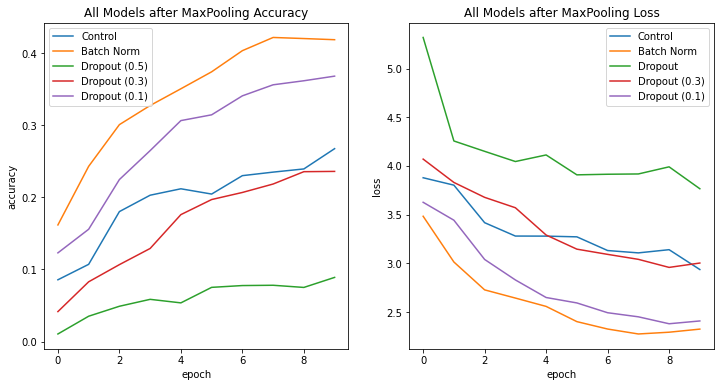

In [ ]:
plotAllModels(history11, history12, history13, history14, history15, "All Models after MaxPooling")

**Exercise**
* Comment every graph by what you state, comparing results
* Have a global view about the three figures of five curves, which performance indicates to the best configuration (BatchNorm, Dropouts) before, after activation functions or after maxpool layer ? 
* In a general case, with the batch norm regularization, can dropout be eliminated ? 
* For a time reason, we trained only 10 epochs, with only a limited set of hyperparameters, now feel free to do your experimental game. Starting from the architecture you find the optimial, modify, add, tune to and then train, to minimise the loss and get a higher accuracy, and share me your experience, and what you concluded

Please, Use your own notebook to implement and organize your work, then pleas email me the following elements: 
 * copy pdf of your notebook
 * share me your notebook to my address mymehio@gmail.com
  * deadline: 08/12 11:59 PM



#Comparisons of every techniques

In [ ]:
def plot1tech(history1, history2, history3, title):
    plt.figure(figsize=(12,6))
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history1.history['val_accuracy'])
    plt.plot(history2.history['val_accuracy'])
    plt.plot(history3.history['val_accuracy'])
    plt.title(title + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['1: DP & BN before activation', '2: DP & BN after activations', '3: BN & DP after maxpooling'], loc='upper left')
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history1.history['val_loss'])
    plt.plot(history2.history['val_loss'])
    plt.plot(history3.history['val_loss'])

    plt.title(title+ ' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['1: DP & BN before activation', '2: DP & BN after activations', '3: BN & DP after maxpooling'], loc='upper right')
    plt.show()
    return None

##Control models

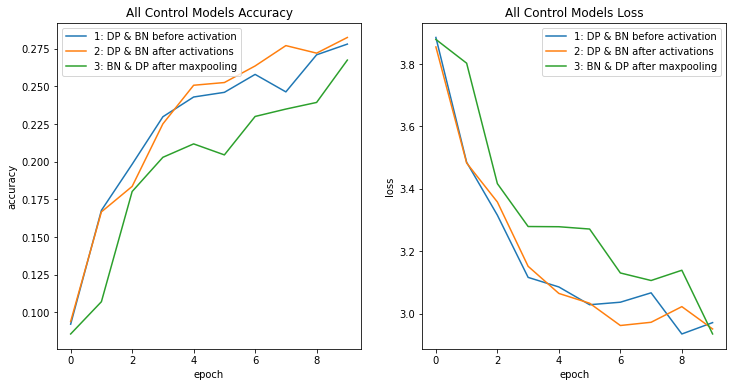

In [ ]:
plot1tech(history1, history6, history11, "All Control Models")

###Interpretation of controls models:
Doing maxpooling after BN & DP is not very efficient compare to others method.
Doing activation before or after doesn't really affects the performances, except that doing it after gives us a smoother curve.
Accuracy isn't good.

So best to worst:

DP & BN after acti > DP & BN before acti > DP & BN after maxpooling

##Batch Normalization  models

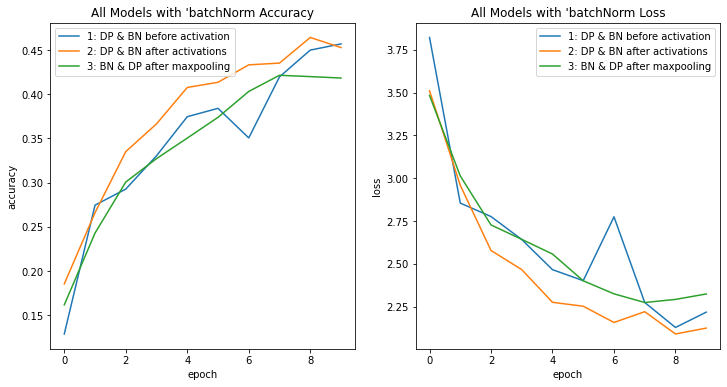

In [ ]:
plot1tech(history2, history7, history12, "All Models with 'batchNorm")

###Interpretation of Batch Norm models:
Doing maxpooling after BN & DP is not very efficient compare to others method.
Doing activation after BN & DP is better performances wise, and gives us a smoother curve.

Accuracy is better but still not amazing.

So best to worst:
DP & BN after acti > DP & BN before acti > DP & BN after maxpooling

##Models where Dropout = 0.5

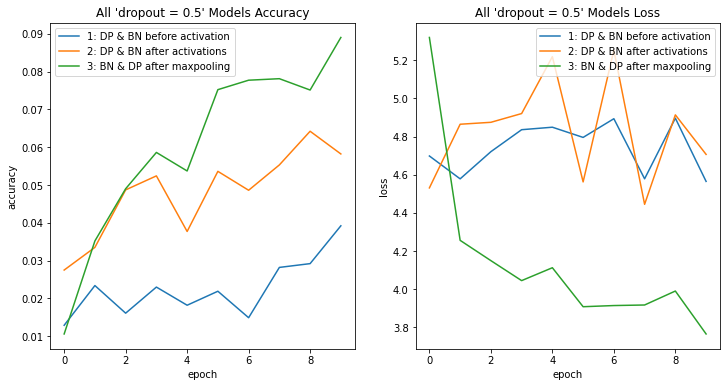

In [ ]:
plot1tech(history3, history8, history13, "All 'dropout = 0.5' Models")

###Interpretation DP = 0.5 models:
Doing maxpooling after BN & DP is better compare to others method.
Doing activation after BN & DP here is worst than doing it before.

Accuracy is bad.

So best to worst:
DP & BN after maxpooling > DP & BN after acti > DP & BN before acti

##Models where Dropout = 0.3

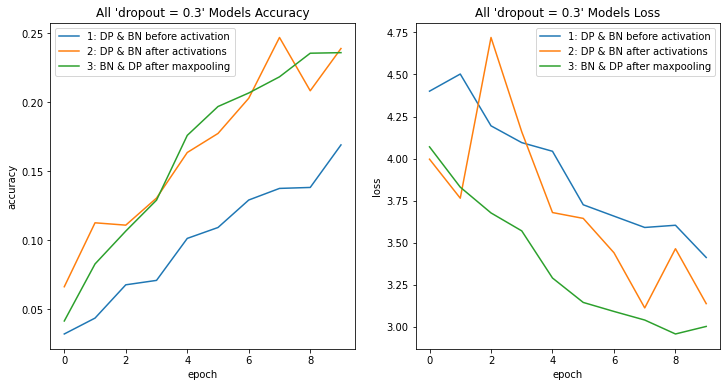

In [ ]:
plot1tech(history4, history9, history14, "All 'dropout = 0.3' Models")

###Interpretation DP = 0.3 models:
Doing maxpooling after BN & DP is better compare to others method and curve is much smoother.
Doing activation after BN & DP here is better than doing it before.

Accuracy is better than DP = 0.5

So best to worst:
DP & BN after maxpooling > DP & BN after acti > DP & BN before acti

##Models where Dropout = 0.1

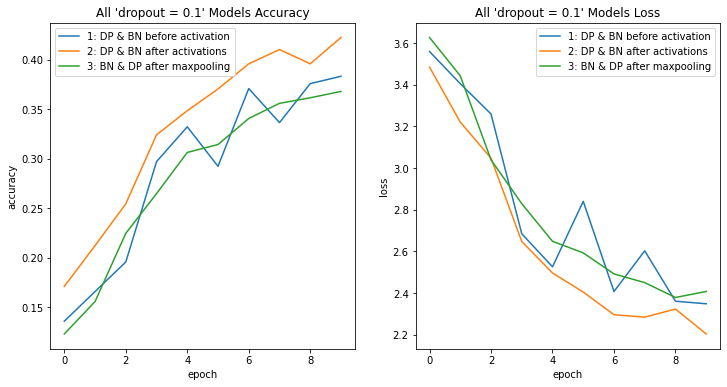

In [ ]:
plot1tech(history5, history10, history15, "All 'dropout = 0.1' Models")

###Interpretation DP = 0.1 models:
Doing activation after BN & DP here is better than doing it before.
BN & DP after maxpooling is average here.

Accuracy is better than DP = 0.5 & 0.3

So best to worst:
DP & BN after acti > DP & BN after maxpooling > DP & BN before acti